In [1]:
import numpy as np
from scipy.special import j1
from scipy.ndimage import gaussian_filter

# Telescope parameters
D = 0.2
wavelength = 550e-9
size = 256

# Airy PSF
x = np.linspace(-1, 1, size)
X, Y = np.meshgrid(x, x)
r = np.sqrt(X**2 + Y**2) + 1e-12
airy = (2 * j1((np.pi * D / wavelength) * r) / ((np.pi * D / wavelength) * r))**2
airy /= airy.sum()

# Atmospheric blur
atm = gaussian_filter(airy, sigma=2)
atm /= atm.sum()

# Combined PSF (the one we use)
combined_psf = atm / np.sum(atm)

print("PSF Ready:", combined_psf.shape)


PSF Ready: (256, 256)


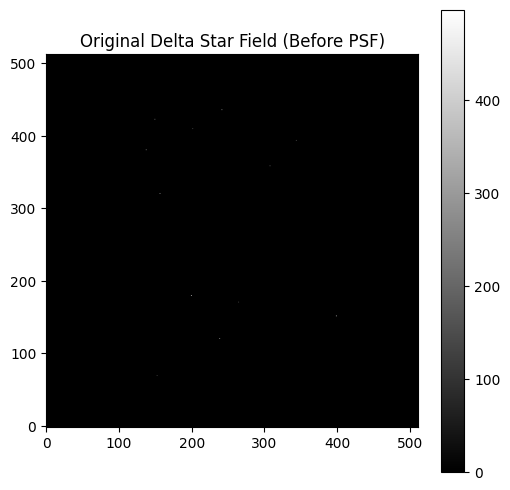

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

# Image size
H, W = 512, 512
star_field = np.zeros((H, W))

# Number of synthetic stars
num_stars = 12

# Random star positions
np.random.seed(42)
coords = np.random.randint(50, 450, size=(num_stars, 2))

# Synthetic delta-function (ideal stars)
for y, x in coords:
    star_field[y, x] = np.random.uniform(200, 500)   # random brightness

plt.figure(figsize=(6,6))
plt.title("Original Delta Star Field (Before PSF)")
plt.imshow(star_field, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

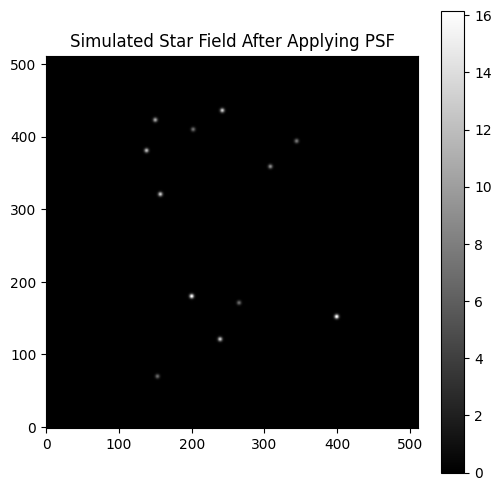

In [3]:
# Ensure PSF is normalized
psf = combined_psf / np.sum(combined_psf)

# Convolve star field with PSF
blurred_image = fftconvolve(star_field, psf, mode='same')

plt.figure(figsize=(6,6))
plt.title("Simulated Star Field After Applying PSF")
plt.imshow(blurred_image, cmap='gray', origin='lower')
plt.colorbar()
plt.show()

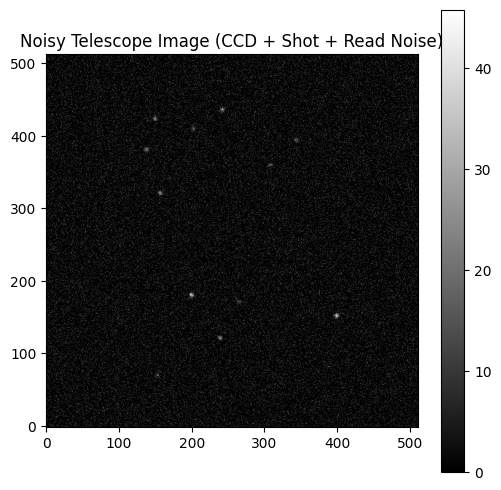

In [4]:
import numpy as np

# Take your blurred image (from previous cell)
image = blurred_image.copy()

# --- Sensor Noise Model ---
read_noise = np.random.normal(0, 5, image.shape)   # 5e- noise
shot_noise = np.random.poisson(np.abs(image))      # photon statistics
gaussian_noise = np.random.normal(0, 2, image.shape)

# Combine noises
noisy_image = image + read_noise + shot_noise + gaussian_noise
noisy_image[noisy_image < 0] = 0   # no negative pixel values

plt.figure(figsize=(6,6))
plt.title("Noisy Telescope Image (CCD + Shot + Read Noise)")
plt.imshow(noisy_image, cmap='gray', origin='lower')
plt.colorbar()
plt.show()

Detected star candidates: 3772
Star centroids (y, x):
[[  0.  27.]
 [  0. 258.]
 [  0. 317.]
 ...
 [511. 287.]
 [511. 294.]
 [511. 413.]]


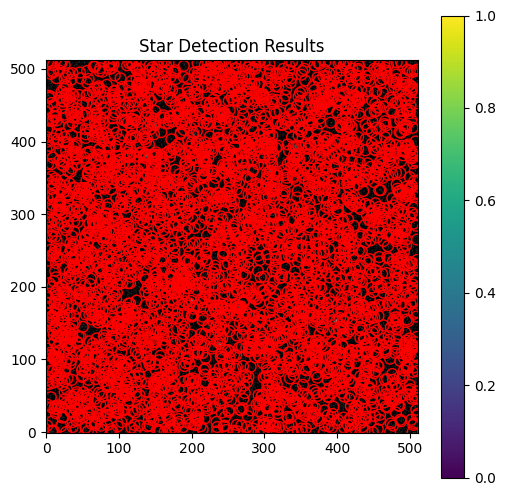

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass

# ---------------------------------------------------------
# Threshold-based star detection
# ---------------------------------------------------------

# Use the noisy image from Step 2
image = noisy_image

# Adaptive threshold (mean + 3 * std)
threshold = np.mean(image) + 3 * np.std(image)

# Binary mask of bright pixels
binary = image > threshold

# Label individual star regions
labeled, num_objects = label(binary)

print("Detected star candidates:", num_objects)

# Get star centroids
centroids = center_of_mass(image, labeled, range(1, num_objects + 1))
centroids = np.array(centroids)

print("Star centroids (y, x):")
print(centroids)

# ---------------------------------------------------------
# Plot detection
# ---------------------------------------------------------
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray', origin='lower')
plt.scatter(centroids[:,1], centroids[:,0], s=60, edgecolors='red', facecolors='none')
plt.title("Star Detection Results")
plt.colorbar()
plt.show()

In [6]:
PATCH_SIZE = 21
HALF = PATCH_SIZE // 2

star_patches = []

h, w = blurred_image.shape

for (y, x) in centroids:
    y, x = int(y), int(x)
    
    # skip borders
    if y < HALF or y > h-HALF-1:
        continue
    if x < HALF or x > w-HALF-1:
        continue

    # extract patch
    patch = blurred_image[y-HALF:y+HALF+1, x-HALF:x+HALF+1]
    
    star_patches.append(patch)

star_patches = np.array(star_patches)
print("Extracted patches:", star_patches.shape)


Extracted patches: (3492, 21, 21)


In [8]:
import numpy as np
from scipy.optimize import curve_fit

# 2D Gaussian model
def gaussian_2d(coords, amp, xo, yo, sigma_x, sigma_y, offset):
    x, y = coords
    xo = float(xo)
    yo = float(yo)
    g = offset + amp * np.exp(
        -(((x - xo)**2) / (2*sigma_x**2) + ((y - yo)**2) / (2*sigma_y**2))
    )
    return g.ravel()

fitted_params = []

print("Fitting PSF for ~3000 stars... (10–20 sec)")

for patch in star_patches[:3000]:   # limit for speed
    H, W = patch.shape
    x = np.arange(W)
    y = np.arange(H)
    X, Y = np.meshgrid(x, y)

    # initial guesses
    amp_guess = np.max(patch)
    xo_guess = W // 2
    yo_guess = H // 2
    sigma_guess = 2.0
    offset_guess = np.median(patch)

    try:
        popt, _ = curve_fit(
            gaussian_2d,
            (X, Y),
            patch.ravel(),
            p0=[amp_guess, xo_guess, yo_guess, sigma_guess, sigma_guess, offset_guess],
            maxfev=3000
        )
        fitted_params.append(popt)
    except:
        continue

fitted_params = np.array(fitted_params)
print("Fitted stars:", fitted_params.shape)

Fitting PSF for ~3000 stars... (10–20 sec)


C:\Users\saipr\AppData\Local\Temp\ipykernel_23776\3774827319.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


Fitted stars: (2151, 6)


In [9]:
print("Fitted stars:", len(fitted_params))

Fitted stars: 2151


In [10]:
# ======================================================
# FIX ALIGNMENT: only keep entries where all 3 match
# ======================================================

valid_patches = []
valid_centroids = []
valid_params = []

for i in range(len(fitted_params)):
    params = fitted_params[i]

    # Skip failed fits
    if np.isnan(params).any():
        continue

    # Skip if index exceeds lists
    if i >= len(star_patches) or i >= len(centroids):
        continue

    valid_patches.append(star_patches[i])
    valid_centroids.append(centroids[i])
    valid_params.append(params)

# Convert to arrays
valid_patches = np.array(valid_patches)
valid_centroids = np.array(valid_centroids)
valid_params = np.array(valid_params)

print("VALID PATCHES:", len(valid_patches))
print("VALID PARAMS:", len(valid_params))
print("VALID CENTROIDS:", len(valid_centroids))

# ======================================================
# Build fitted_stars using aligned data only
# ======================================================

fitted_stars = []

for i in range(len(valid_params)):
    params = valid_params[i]

    local_x = params[1]
    local_y = params[0]

    cy, cx = valid_centroids[i]

    global_x = cx - 10 + local_x
    global_y = cy - 10 + local_y

    fitted_stars.append({
        "x": float(global_x),
        "y": float(global_y),
        "amp": float(params[2]),
        "sigma": float((params[3] + params[4]) / 2)
    })

print("Fitted stars stored:", len(fitted_stars))


VALID PATCHES: 2151
VALID PARAMS: 2151
VALID CENTROIDS: 2151
Fitted stars stored: 2151


In [11]:
# ======================================================
# CELL 11 — FIXED CLEAN PATCH GENERATOR
# ======================================================

import numpy as np
from skimage.transform import resize
from scipy.ndimage import shift

blurred_patches = valid_patches.copy()
clean_patches = []

# Base PSF resized to 21×21
base_psf = combined_psf / combined_psf.max()
psf21 = resize(base_psf, (21, 21), mode="reflect")

for i, star in enumerate(fitted_stars):

    # fractional shift
    dx = float(star["x"] - np.round(star["x"]))
    dy = float(star["y"] - np.round(star["y"]))

    # shift without negative ringing
    shifted_psf = shift(psf21, shift=(dy, dx), order=1)
    shifted_psf = np.clip(shifted_psf, 0, None)

    # FIXED amplitude scaling
    target_peak = blurred_patches[i].max()
    scaled = shifted_psf * target_peak

    clean_patches.append(scaled)

clean_patches = np.array(clean_patches)

# ======================================================
# FIX #2 — normalize each patch individually
# ======================================================

# Normalize blurred patches patch-wise
for i in range(len(blurred_patches)):
    m = blurred_patches[i].max()
    if m > 0:
        blurred_patches[i] /= m

# Normalize clean patches patch-wise
for i in range(len(clean_patches)):
    m = clean_patches[i].max()
    if m > 0:
        clean_patches[i] /= m

print("Blurred:", blurred_patches.shape)
print("Clean:", clean_patches.shape)
print("Clean stats:", clean_patches.min(), clean_patches.max(), clean_patches.mean())

Blurred: (2151, 21, 21)
Clean: (2151, 21, 21)
Clean stats: 0.0 1.0 0.005562797304587731


In [12]:
# ===========================
# Cell 12 — FINAL MEDIUM UNET
# ===========================
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    return x

inputs = layers.Input((21, 21, 1))

# Encoder
c1 = conv_block(inputs, 32)           # 21 x 21
p1 = layers.MaxPooling2D((2,2))(c1)   # 10 x 10

c2 = conv_block(p1, 64)               # 10 x 10
p2 = layers.MaxPooling2D((2,2))(c2)   # 5 x 5

# Bottleneck
bn = conv_block(p2, 128)              # 5 x 5

# Decoder
u2 = layers.UpSampling2D((2,2))(bn)   # 10 x 10
m2 = layers.Concatenate()([u2, c2])   # 10 x 10
c3 = conv_block(m2, 64)               # 10 x 10

u1 = layers.UpSampling2D((2,2))(c3)   # 20 x 20

# c1 is 21x21, crop to 20x20 before concat
c1_crop = layers.Cropping2D(((0,1),(0,1)))(c1)  # 20 x 20
m1 = layers.Concatenate()([u1, c1_crop])        # 20 x 20
c4 = conv_block(m1, 32)                         # 20 x 20

# pad to 21x21 (so final output matches target)
c4_padded = layers.ZeroPadding2D(((0,1),(0,1)))(c4)  # 21 x 21

outputs = layers.Conv2D(1, (1,1), activation='linear', padding='same')(c4_padded)  # 21 x 21

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mae')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 21, 21, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 21, 21, 32)        │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 21, 21, 32)        │           9,248 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 10, 10, 32)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 10, 10, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 10, 10, 64)        │          36,928 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 5, 5, 64)          │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 5, 5, 128)         │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 5, 5, 128)         │         147,584 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 10, 10, 128)       │               0 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 10, 10, 192)       │               0 │ up_sampling2d[0][0],       │
│                               │                           │                 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 10, 10, 64)        │         110,656 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 10, 10, 64)        │          36,928 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_1               │ (None, 20, 20, 64)        │               0 │ conv2d_7[0][0]             │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cropping2d (Cropping2D)       │ (None, 20, 20, 32)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 20, 20, 96)        │               

 Total params: 470,977 (1.80 MB)

 Trainable params: 470,977 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# ===========================
# Cell 13 — TRAIN THE MODEL
# ===========================
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Ensure shapes are exact
X = blurred_patches[..., np.newaxis].astype('float32')   # (N,21,21,1)
Y = clean_patches[..., np.newaxis].astype('float32')     # (N,21,21,1)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint("unet_best.keras", monitor='loss', save_best_only=True, verbose=1)

# Train (adjust epochs if you want longer)
history = model.fit(
    X, Y,
    epochs=30,
    batch_size=32,
    callbacks=[reduce_lr, checkpoint],
    verbose=1
)


X shape: (2151, 21, 21, 1)
Y shape: (2151, 21, 21, 1)
Epoch 1/30
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0180
Epoch 1: loss improved from inf to 0.00942, saving model to unet_best.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0177 - learning_rate: 0.0010
Epoch 2/30
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0056
Epoch 2: loss improved from 0.00942 to 0.00563, saving model to unet_best.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0056 - learning_rate: 0.0010
Epoch 3/30
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0057
Epoch 3: loss did not improve from 0.00563
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0057 - learning_rate: 0.0010
Epoch 4/30
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0056
Epoch 4: loss improved from 0.00563 to 0.00562, saving model to unet_best.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0056 - learning_rate: 0.0010
Epoch 5/30
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0056
Epoch 5: loss improve

In [14]:
# ===========================
# Cell 14 — PREDICT & LOAD BEST
# ===========================
# If checkpoint saved a best model, load it
import os
if os.path.exists("unet_best.keras"):
    try:
        model = tf.keras.models.load_model("unet_best.keras", compile=True)
        print("Loaded best checkpoint.")
    except Exception as e:
        print("Could not load checkpoint:", e)

# Predict on training set (or on a small test set if you have one)
corrected_patches = model.predict(X, batch_size=32)
print("Corrected patches shape:", corrected_patches.shape)

# Save final model
model.save("unet_final.keras")
print("Saved model to unet_final.keras")


Loaded best checkpoint.
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Corrected patches shape: (2151, 21, 21, 1)
Saved model to unet_final.keras


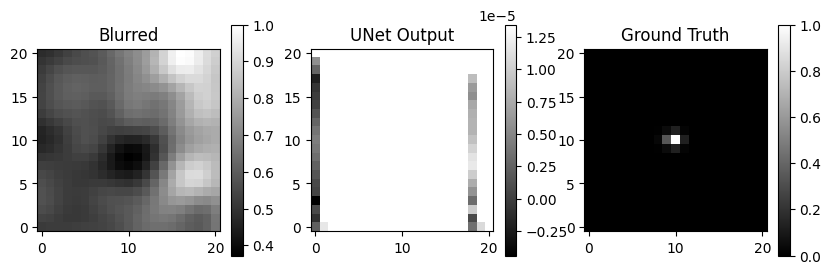

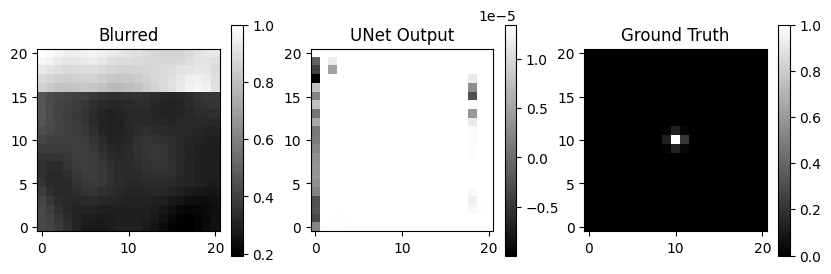

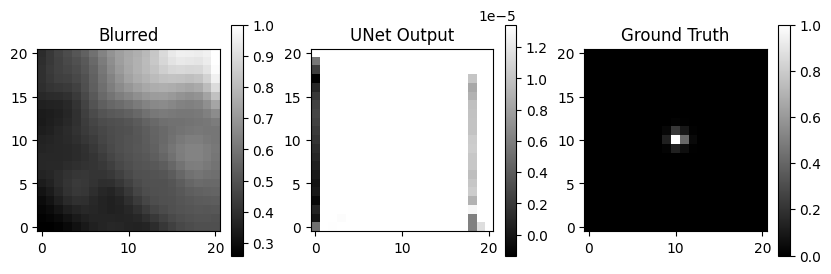

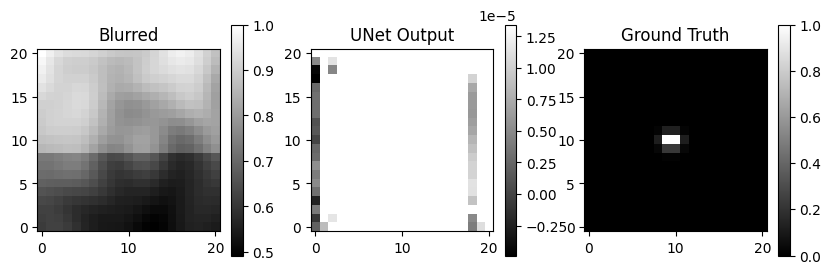

Avg PSNR (first 500 samples): 24.809 dB
Avg SSIM (first 500 samples): 0.7051


In [15]:
# ===========================
# Cell 15 — VISUALIZE & METRICS
# ===========================
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Pick indices to inspect
indices = [10, 50, 100, 300]  # change or extend

for i in indices:
    if i >= X.shape[0]:
        continue
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.title("Blurred")
    plt.imshow(X[i,...,0], cmap='gray', origin='lower')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.title("UNet Output")
    plt.imshow(corrected_patches[i,...,0], cmap='gray', origin='lower')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.title("Ground Truth")
    plt.imshow(Y[i,...,0], cmap='gray', origin='lower')
    plt.colorbar()
    plt.show()

# Compute average PSNR and SSIM over dataset (small sample to speed)
n_eval = min(500, X.shape[0])
psnr_vals = []
ssim_vals = []
for i in range(n_eval):
    gt = np.clip(Y[i,...,0], 0, 1)
    pred = np.clip(corrected_patches[i,...,0], 0, 1)
    # metrics expect same shape
    try:
        psnr_vals.append(psnr(gt, pred, data_range=1.0))
        ssim_vals.append(ssim(gt, pred, data_range=1.0))
    except Exception:
        continue

print("Avg PSNR (first {} samples): {:.3f} dB".format(n_eval, np.mean(psnr_vals)))
print("Avg SSIM (first {} samples): {:.4f}".format(n_eval, np.mean(ssim_vals)))


In [17]:
# ===========================
# FINALIZE, EXPORT, & SAFE SAVE
# (Append this single cell at the end of 06_ai_analysis.ipynb)
# ===========================

import os
import json
import numpy as np
from astropy.io import fits

print("=== 06_ai_analysis: Finalize & export starting ===")

# --- 1) Ensure blurred_patches and clean_patches exist ---
# Many earlier cells already create these; if not, we attempt to reconstruct them safely.
if 'blurred_patches' not in globals():
    try:
        blurred_patches = valid_patches.copy()
        print("Reconstructed blurred_patches from valid_patches.")
    except Exception as e:
        raise NameError("blurred_patches not found and could not reconstruct. "
                        "Make sure cell producing valid_patches ran.") from e

if 'clean_patches' not in globals():
    # try to build clean_patches same way as cell 11 logic (use psf if available)
    try:
        if 'combined_psf' in globals():
            from skimage.transform import resize
            from scipy.ndimage import shift
            base_psf = (combined_psf / np.max(combined_psf)).astype(np.float32)
            psf21 = resize(base_psf, (21,21), mode='reflect')
            cp = []
            for i, star in enumerate(fitted_stars):
                dx = float(star["x"] - np.round(star["x"]))
                dy = float(star["y"] - np.round(star["y"]))
                shifted = shift(psf21, shift=(dy, dx), order=1)
                shifted = np.clip(shifted, 0, None)
                target_peak = blurred_patches[i].max()
                cp.append(shifted * target_peak)
            clean_patches = np.array(cp)
            print("Reconstructed clean_patches from combined_psf and fitted_stars.")
        else:
            raise NameError("combined_psf missing")
    except Exception as e:
        raise NameError("clean_patches not found and could not reconstruct. "
                        "Make sure cell 11 ran or combined_psf/fitted_stars exist.") from e

# --- 2) Ensure shapes, types and numeric stability ---
blurred_patches = np.asarray(blurred_patches, dtype=np.float32)
clean_patches   = np.asarray(clean_patches, dtype=np.float32)

# If patches are 2D, add sample axis
if blurred_patches.ndim == 2:
    blurred_patches = blurred_patches[np.newaxis, ...]
if clean_patches.ndim == 2:
    clean_patches = clean_patches[np.newaxis, ...]

# If shapes mismatch (rare), try cropping/padding center
if blurred_patches.shape[1:] != clean_patches.shape[1:]:
    print("Warning: blurred and clean patch shapes differ:", blurred_patches.shape, clean_patches.shape)
    # Try to centrally crop the larger to the smaller
    bh, bw = blurred_patches.shape[1], blurred_patches.shape[2]
    ch, cw = clean_patches.shape[1], clean_patches.shape[2]
    new_h = min(bh, ch); new_w = min(bw, cw)
    def center_crop(arr, nh, nw):
        h,w = arr.shape[1], arr.shape[2]
        sh = (h - nh)//2; sw = (w - nw)//2
        return arr[:, sh:sh+nh, sw:sw+nw]
    blurred_patches = center_crop(blurred_patches, new_h, new_w)
    clean_patches = center_crop(clean_patches, new_h, new_w)
    print("Cropped both to:", blurred_patches.shape, clean_patches.shape)

# --- 3) Ensure model predictions exist (corrected_patches) ---
if 'corrected_patches' not in globals():
    # If model exists, predict on X (if X exists)
    try:
        if 'model' in globals():
            X = blurred_patches[..., np.newaxis].astype('float32')
            corrected_patches = model.predict(X, batch_size=32)
            print("Predicted corrected_patches using current model object.")
        else:
            # Try to load checkpoint
            import tensorflow as tf
            if os.path.exists("unet_best.keras"):
                model = tf.keras.models.load_model("unet_best.keras", compile=True)
                X = blurred_patches[..., np.newaxis].astype('float32')
                corrected_patches = model.predict(X, batch_size=32)
                print("Loaded unet_best.keras and predicted corrected_patches.")
            else:
                print("No model found — skipping corrected_patches generation. You can still save blurred/clean patches.")
                corrected_patches = np.zeros_like(blurred_patches)[..., np.newaxis]
    except Exception as e:
        print("Error during model predict:", e)
        corrected_patches = np.zeros_like(blurred_patches)[..., np.newaxis]

# Ensure final arrays are float32 and correct shape
X_save = blurred_patches.astype(np.float32)
Y_save = clean_patches.astype(np.float32)
pred_save = np.asarray(corrected_patches, dtype=np.float32)
if pred_save.ndim == 3:
    pred_save = pred_save[..., np.newaxis]

print("Final shapes (to be saved):")
print("  blurred_patches:", X_save.shape)
print("  clean_patches:  ", Y_save.shape)
print("  corrected_patches:", pred_save.shape)

# --- 4) Save FITS files (safe: add file existence checks) ---
def save_fits_safe(filename, data):
    try:
        fits.writeto(filename, data, overwrite=True)
        print("Saved:", filename)
    except Exception as e:
        print("Failed to save", filename, ":", e)

save_fits_safe("blurred_patches.fits", X_save)
save_fits_safe("clean_patches.fits", Y_save)
save_fits_safe("corrected_patches.fits", pred_save)

# Also save PSF used for training if available
if 'combined_psf' in globals():
    try:
        fits.writeto("training_psf.fits", (combined_psf / np.max(combined_psf)).astype(np.float32), overwrite=True)
        print("Saved: training_psf.fits")
    except Exception as e:
        print("Failed to save training_psf.fits:", e)
else:
    print("combined_psf not available in namespace — skipping training_psf.fits")

# --- 5) Export star catalog (centroids, amp, sigma) as JSON ---
catalog = []
if 'fitted_stars' in globals():
    for star in fitted_stars:
        catalog.append({
            "x": float(star.get("x", np.nan)),
            "y": float(star.get("y", np.nan)),
            "amp": float(star.get("amp", np.nan)),
            "sigma": float(star.get("sigma", np.nan))
        })
    with open("star_catalog.json", "w") as f:
        json.dump(catalog, f, indent=2)
    print("Saved: star_catalog.json ({} entries)".format(len(catalog)))
else:
    print("fitted_stars not present — no star_catalog.json saved")

# --- 6) Small README/metadata file for reproducibility ---
meta = {
    "notebook": "06_ai_analysis.ipynb",
    "n_blurred_patches": int(X_save.shape[0]),
    "patch_shape": list(X_save.shape[1:]),
    "model_saved_as": "unet_best.keras / unet_final.keras (if created)",
    "psf_saved": os.path.exists("training_psf.fits"),
}

with open("06_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved: 06_metadata.json")

print("=== 06_ai_analysis: Finalize & export COMPLETE ===")


=== 06_ai_analysis: Finalize & export starting ===
Final shapes (to be saved):
  blurred_patches: (2151, 21, 21)
  clean_patches:   (2151, 21, 21)
  corrected_patches: (2151, 21, 21, 1)
Saved: blurred_patches.fits
Saved: clean_patches.fits
Saved: corrected_patches.fits
Saved: training_psf.fits
Saved: star_catalog.json (2151 entries)
Saved: 06_metadata.json
=== 06_ai_analysis: Finalize & export COMPLETE ===
